# 🔹 Paso 1 – Descargar el dataset desde torchvision


In [1]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
import numpy as np
from torchvision.datasets import FashionMNIST

#Cargamos los dataset sin el transformador
train_dataset = FashionMNIST(root='./data', train=True, download=True)
test_dataset = FashionMNIST(root='./data', train=False, download=True)




# 🔹 Paso 2 – Extraer datos crudos

In [2]:
# Convertimos los datos a numpy arrays

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

#Dividimos el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Datos del test sin cambios
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()


# 🔹 Paso 3 – Preprocesado para Random Forest

In [3]:
from utils import scale_datasets

# Aplanamos los datos para que tengan la forma (num_samples, 1, 28, 28)
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)


# O si quieres quedarte con el scaler para aplicarlo luego al test
scaled_sets, scaler = scale_datasets([X_train_flat, X_val_flat,X_test_flat], method='minmax', return_scaler=True)
X_train_scaled, X_val_scaled ,X_test_scaled= scaled_sets

# 🔹 Paso 4 – Etrenando modelo

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Entrenamos el modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predecimos en validación
y_val_pred = rf.predict(X_val_scaled)

# Evaluamos
val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, average='macro')

print(f"Accuracy en validación: {val_accuracy:.4f}")
print(f"Recall en validación: {val_recall:.4f}")


Accuracy en validación: 0.8812
Recall en validación: 0.8817


# Creando una matriz de confusión

Clases del dataset: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Diccionario de clases: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


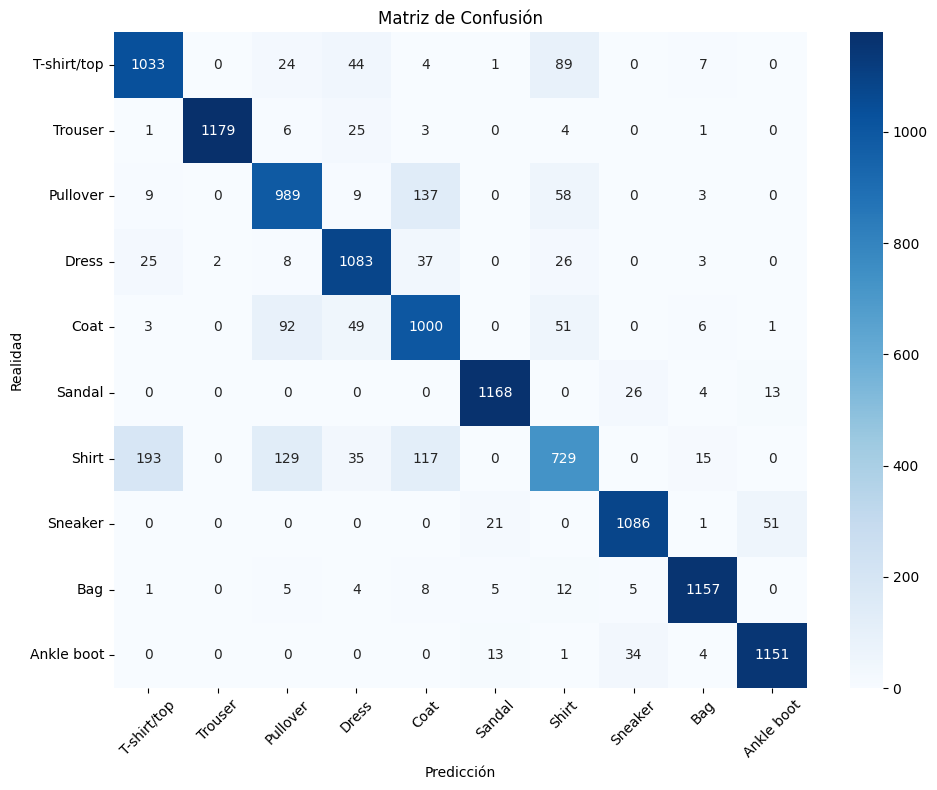

In [5]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion
import seaborn as sns
import matplotlib.pyplot as plt
# Printemamos las clases que tiene el dataset
print("Clases del dataset:", train_dataset.classes)
 # Creamos un diccionario para mapear las etiquetas a los nombres de las clases
class_names = {i: name for i, name in enumerate(train_dataset.classes)}
# Imprimimos el diccionario
print("Diccionario de clases:", class_names)

# Creamos la matriz de confusión
matriz_confusion = confusion_matrix(y_val, y_val_pred)
#Convertimos los indices a etiquetas
labels = [class_names[i] for i in range(10)]

#Display de la matriz de confusión
plot_confusion(y_val, y_val_pred, class_names)



## Mostrando acierto por clase


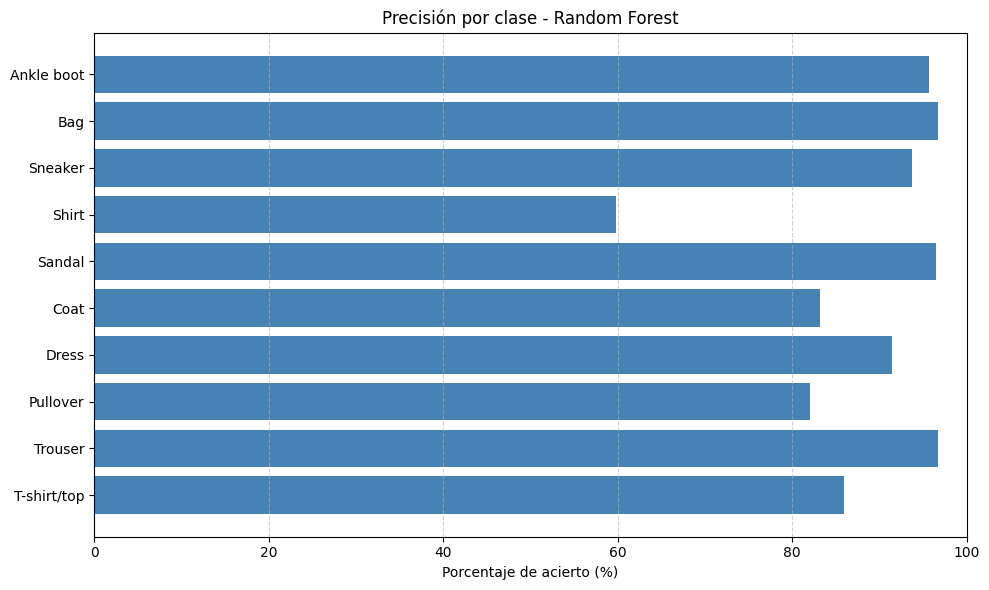

In [6]:
#Calvulamos el acierto por clase

aciertos_por_clase = np.diag(matriz_confusion) / np.sum(matriz_confusion, axis=1)* 100
#Creamos la gráfica 
plt.figure(figsize=(10, 6))
plt.barh(labels, aciertos_por_clase, color='steelblue')
plt.xlabel("Porcentaje de acierto (%)")
plt.title("Precisión por clase - Random Forest")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Evaluación del modelo con el conjunto de test

In [7]:
from sklearn.metrics import accuracy_score, recall_score, classification_report
from utils import evaluate_model_metrics
# Obtencion de las predicciones del test
y_test_pred = rf.predict(X_test_scaled)
# Evaluamos en test
test_accuracy = accuracy_score(y_test, y_test_pred)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='macro')

# En conjunto de test
metrics_rf = evaluate_model_metrics(y_test, y_test_pred, average='macro', title='Random Forest - Test')




📊 Random Forest - Test
Accuracy:  0.8739
Precision (macro): 0.8730
Recall (macro):    0.8739
F1-score (macro):  0.8726


# 🧩 Paso 6: Entrenar una red neuronal para comparar con el modelo de Random Forest

🧱 Paso 6.1: Convertir a tensores y crear TensorDataset Y Dataloaders

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import create_dataloaders

dataloaders =create_dataloaders(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, batch_size=64)



# 🧩 Paso 7: Definir la red neuronal

In [9]:
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(NeuralNet, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 256),   # Capa 1
            nn.ReLU(),                    # Activación
            nn.Dropout(0.3),              # Regularización

            nn.Linear(256, 128),          # Capa 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)   # Capa de salida
        )

    def forward(self, x):
        return self.network(x)
model = NeuralNet()


# 🧩 Paso 8: Entrenamiento del modelo NeuralNet

In [10]:
from utils import train_model
import torch.nn as nn
import torch.optim as optim

# Instanciar red y componentes
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
metrics = train_model(model, dataloaders['train'], dataloaders['val'], criterion, optimizer, epochs=8)




🚀 Comenzando entrenamiento (8 epochs)...

Epoch 1/8 | Train Loss: 0.6244 | Val Loss: 0.4584 | Train Acc: 0.7734 | Val Acc: 0.8347 | Train F1: 0.7692 | Val F1: 0.8291
Epoch 2/8 | Train Loss: 0.4404 | Val Loss: 0.3903 | Train Acc: 0.8409 | Val Acc: 0.8563 | Train F1: 0.8396 | Val F1: 0.8555
Epoch 3/8 | Train Loss: 0.3990 | Val Loss: 0.3773 | Train Acc: 0.8538 | Val Acc: 0.8613 | Train F1: 0.8527 | Val F1: 0.8597
Epoch 4/8 | Train Loss: 0.3748 | Val Loss: 0.3594 | Train Acc: 0.8626 | Val Acc: 0.8716 | Train F1: 0.8617 | Val F1: 0.8729
Epoch 5/8 | Train Loss: 0.3620 | Val Loss: 0.3590 | Train Acc: 0.8668 | Val Acc: 0.8674 | Train F1: 0.8659 | Val F1: 0.8666
Epoch 6/8 | Train Loss: 0.3442 | Val Loss: 0.3297 | Train Acc: 0.8736 | Val Acc: 0.8803 | Train F1: 0.8727 | Val F1: 0.8800
Epoch 7/8 | Train Loss: 0.3299 | Val Loss: 0.3211 | Train Acc: 0.8789 | Val Acc: 0.8843 | Train F1: 0.8781 | Val F1: 0.8839
Epoch 8/8 | Train Loss: 0.3224 | Val Loss: 0.3203 | Train Acc: 0.8807 | Val Acc: 0.8802 |

Printeamos los resultados de la red neuronal.

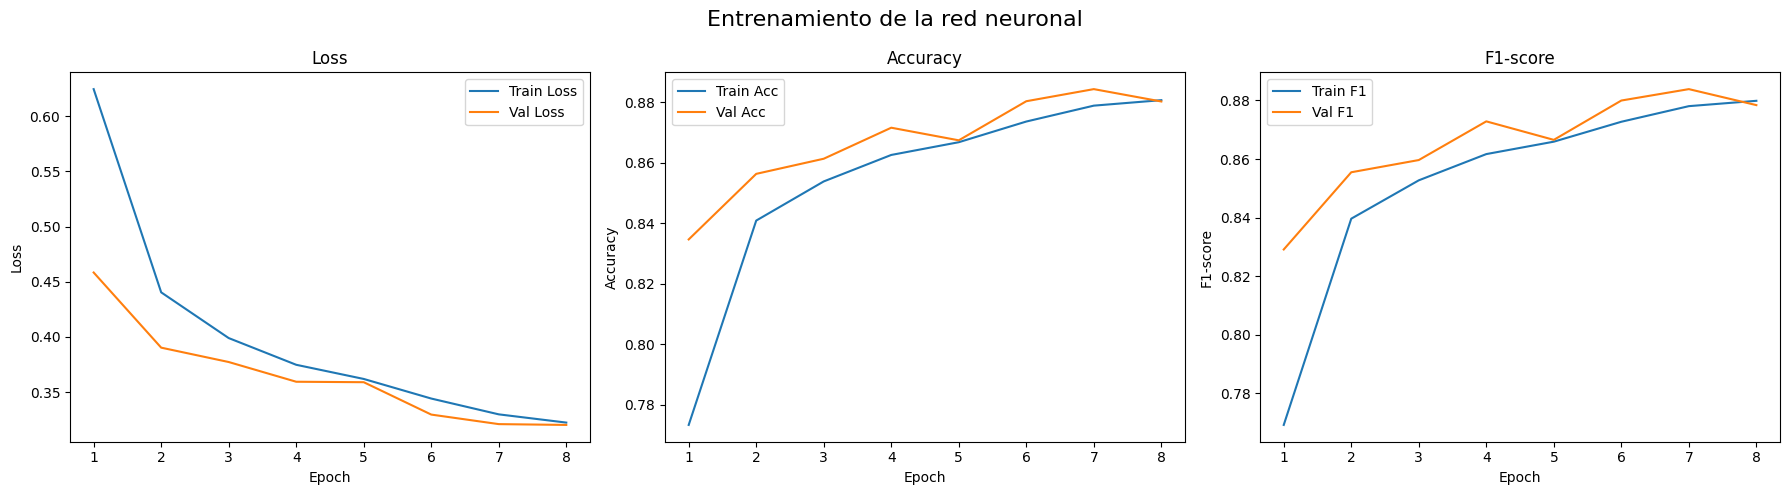

In [11]:
from utils import plot_training_metrics

plot_training_metrics(metrics, title='Entrenamiento de la red neuronal')


Comprobamos el modelo en test

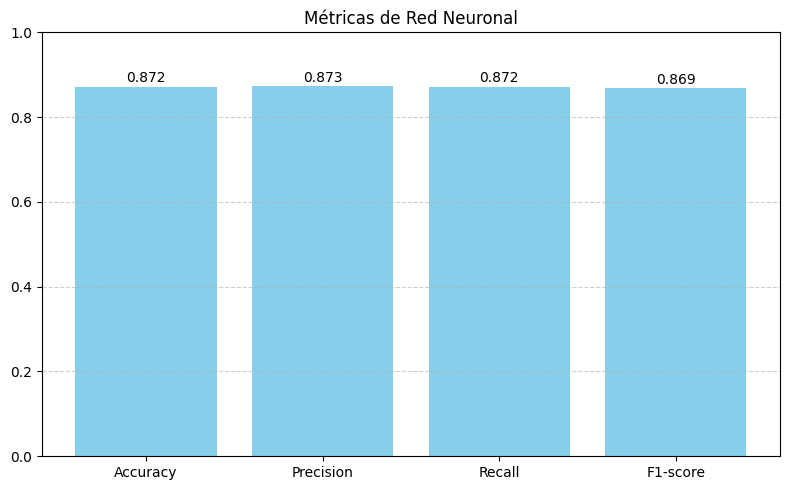

In [12]:
from utils import validate_model, plot_model_metrics
nn_metrics = validate_model(model, dataloaders['test'])
plot_model_metrics(nn_metrics, model_name='Red Neuronal')


Comparacion entre los dos modelos

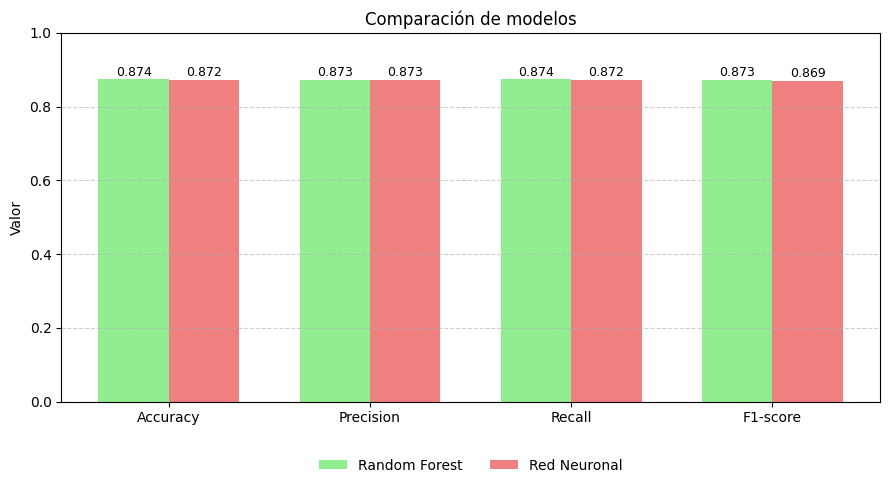

In [13]:
from utils import evaluate_model_metrics, plot_comparison_metrics
plot_comparison_metrics(metrics_rf, nn_metrics, label1='Random Forest', label2='Red Neuronal')